In [1]:
#! pip install -q tensorflow-model-optimization
#! pip install tensorflow-addons

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from LTH_helper import prune_and_initilize

https://arxiv.org/abs/1803.03635

https://www.youtube.com/watch?v=0VH1Lim8gL8&feature=youtu.be&t=2760

In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
import os
import random as rn
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow_model_optimization as tfmot
from tensorflow.keras import initializers
from tensorflow.keras.datasets import fashion_mnist, mnist

In [5]:
def set_random_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(seed)
    rn.seed(seed)
    tf.random.set_seed(seed)
    # session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    # sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    # K.set_session(sess)

# Cargo datos

In [6]:
my_dataset = fashion_mnist

In [7]:
(train_images, train_labels), (test_images, test_labels) = my_dataset.load_data()
X = train_images.reshape(-1, 784)/255
y = train_labels.reshape(-1, 1)
X_test = test_images.reshape(-1, 784)/255
y_test = test_labels.reshape(-1, 1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

# Red neuronal básica

In [8]:
def compile_model(model, lr=0.001):
    optim = optimizers.Adam(lr=lr)
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

In [9]:
def get_model(compile_model_flag=True, lr=0.001):
    reduce = 2
    input_dim=784
    output_size = 10
    # Creo el modelo
    model = Sequential()
    model.add(Dense(784*2//reduce, activation='linear', name='hidden_1', kernel_initializer=initializers.glorot_uniform(),
                    input_dim=input_dim))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(784//reduce, activation='linear', name='hidden_2', kernel_initializer=initializers.glorot_uniform(),
                   ))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(output_size, name='Salida', kernel_initializer=initializers.glorot_uniform(),
                   ))
    model.add(Activation('softmax'))
    if compile_model_flag:
        compile_model(model, lr=lr)
    return model
model = get_model()
# model.save_weights('random-init.hdf5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 784)               615440    
_________________________________________________________________
activation (Activation)      (None, 784)               0         
_________________________________________________________________
hidden_2 (Dense)             (None, 392)               307720    
_________________________________________________________________
activation_1 (Activation)    (None, 392)               0         
_________________________________________________________________
Salida (Dense)               (None, 10)                3930      
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 927,090
Trainable params: 927,090
Non-trainable params: 0
__________________________________________________

![LTH_alg.png](LTH_alg.png)

# Step 1 and 2. Initialize and Train network

In [10]:
def get_callbacks(filename):
    return [
        # ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=np.sqrt(0.1), patience=10, verbose=1, min_lr=1e-4),
        ModelCheckpoint(filepath=filename,  verbose=0, save_best_only=True, monitor='val_accuracy', mode='max')
    ]

In [11]:
# Step 1 
model = get_model()
batch_size = 512
epochs = 20
# Save initial weights
initial_weights = 'mlp.mnist.initial_weights.hdf5'
best_weights = 'mlp.mnist.first_train.hdf5'
model.save_weights(initial_weights)
history_1 = model.fit(X_train, 
           y_train,
           epochs=epochs, batch_size=batch_size, 
           validation_data = (X_val, y_val),
           verbose=0, 
           callbacks=get_callbacks(best_weights)
          )

In [12]:
print(model.evaluate(X_test, y_test, verbose=0))
model.load_weights('mlp.mnist.first_train.hdf5')
print(model.evaluate(X_test, y_test, verbose=0))

[0.3509059548377991, 0.8891000151634216]
[0.3341708779335022, 0.890500009059906]


# Step 3 and 4. Get Trainned pruned model and load initial random weights

In [13]:
# Get prunned model with correct mask
pm = 0.5 # Porcentage of weights not pruned
untrained_pruned_model = prune_and_initilize(model, pm, initial_weights)

Instructions for updating:
Please use `layer.add_weight` method instead.


In [14]:
untrained_pruned_model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 765us/step - loss: 1.3981 - accuracy: 0.6953


[1.3980684280395508, 0.6952999830245972]

# Train pruned model

In [15]:
def get_prunned_callbacks(filename):
    return get_callbacks(filename) + [tfmot.sparsity.keras.UpdatePruningStep()]

In [16]:
epochs = 20
batch_size = 512
compile_model(untrained_pruned_model)
history_2 = untrained_pruned_model.fit(X_train, 
               y_train,
               epochs=epochs, batch_size=batch_size, 
              validation_data = (X_val, y_val),
               verbose=0, 
                    shuffle = True,
                           callbacks=get_prunned_callbacks(best_weights)
              )

In [17]:
print(untrained_pruned_model.evaluate(X_test, y_test, verbose=0))
untrained_pruned_model.load_weights(best_weights)
untrained_pruned_model.evaluate(X_test, y_test, verbose=0)

[0.37906813621520996, 0.892300009727478]


[0.3272017538547516, 0.8944000005722046]

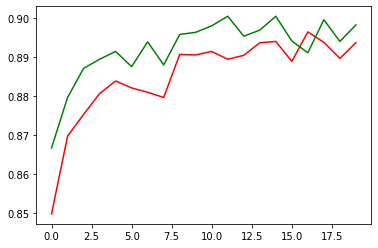

In [18]:
plt.plot(history_1.history['val_accuracy'], c='r')
plt.plot(history_2.history['val_accuracy'], c='g')

# Re-train reducing pm

In [19]:
new_pm = pm**(1/2)*pm
print(new_pm)
untrained_pruned_model = prune_and_initilize(untrained_pruned_model, pm, initial_weights)

0.3535533905932738


In [20]:
untrained_pruned_model.evaluate(X_train, y_train)

1594/1594 [==============================] - 1s 762us/step - loss: 1.3819 - accuracy: 0.7085


[1.3818621635437012, 0.7085098028182983]

In [21]:
epochs = 20
batch_size = 512
compile_model(untrained_pruned_model)
history_3 = untrained_pruned_model.fit(X_train, 
               y_train,
               epochs=epochs, batch_size=batch_size, 
              validation_data = (X_val, y_val),
               verbose=0, 
                    shuffle = True,
                           callbacks=get_prunned_callbacks(best_weights)
              )

In [22]:
print(untrained_pruned_model.evaluate(X_test, y_test, verbose=0))
untrained_pruned_model.load_weights(best_weights)
print(untrained_pruned_model.evaluate(X_test, y_test, verbose=0))

[0.3876347541809082, 0.8902000188827515]
[0.34668153524398804, 0.8952000141143799]


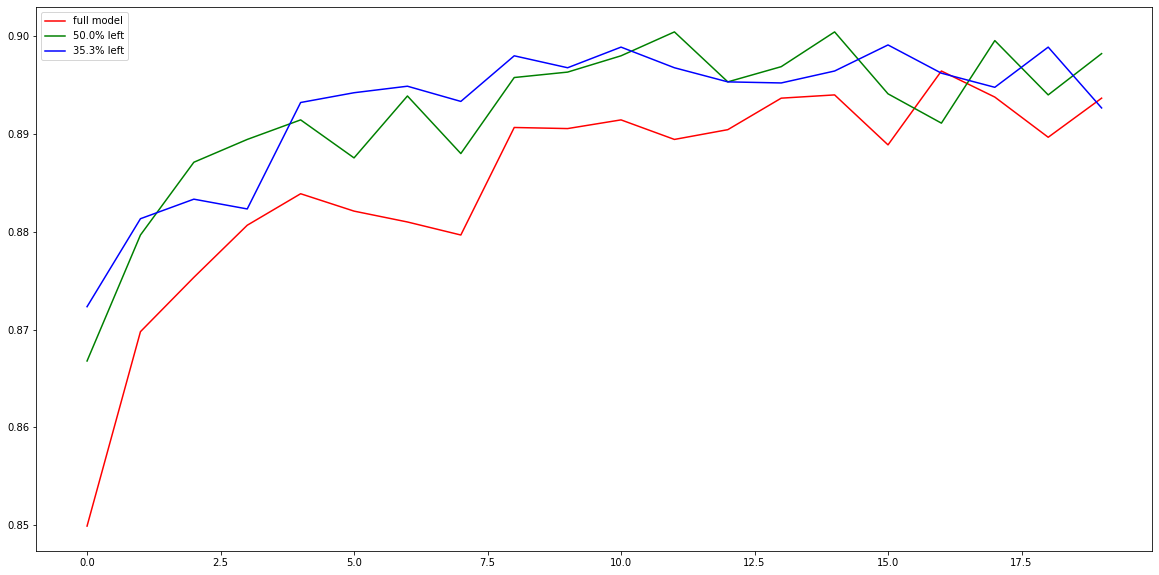

In [23]:
plt.figure(figsize=(20,10))
plt.plot(history_1.history['val_accuracy'], c='r', label='full model')
plt.plot(history_2.history['val_accuracy'], c='g', label=f'{int(pm*1000)/10}% left')
plt.plot(history_3.history['val_accuracy'], c='b', label=f'{int(new_pm*1000)/10}% left')
plt.legend()

In [24]:
from tensorflow_model_optimization.sparsity.keras import strip_pruning

In [47]:
last_model = strip_pruning(pruned_model_2)
compile_model(last_model)
last_model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 788us/step - loss: 0.4631 - accuracy: 0.8977


[0.4630688428878784, 0.8977000117301941]

In [48]:
(last_model.get_weights()[2] == 0).sum()/(last_model.get_weights()[2] != 1).sum()

0.6464461422324032

In [49]:
weights = last_model.get_weights()
for i, w in enumerate(weights):
    print(w.shape)

(784, 784)
(784,)
(784, 392)
(392,)
(392, 10)
(10,)


In [50]:
neurons_to_kill = np.where((weights[4]!=0).sum(axis=1) == 0)
len(neurons_to_kill[0])

26

In [51]:
weights[2][:, neurons_to_kill] = 0

In [52]:
last_model.set_weights(weights)
last_model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 794us/step - loss: 0.4631 - accuracy: 0.8977


[0.4630688428878784, 0.8977000117301941]

In [53]:
(last_model.get_weights()[2] == 0).sum()/(last_model.get_weights()[2] != 1).sum()

0.666942159516868